In [1]:
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/balakrishnan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [3]:
def set_seeds(seed: int = 42):
    """
    Sets random seeds for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Get data

In [4]:
import os, zipfile, requests
from pathlib import Path

def download_data(
    source: str,
    destination: str,
    remove_source: bool = True
) -> Path:
    """
    Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(
            source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
            destination='pizza_steak_sushi
        )
    """
    data_path = Path('data/')
    image_path = data_path / destination
    if image_path.is_dir():
        print('[INFO]', image_path, 'directory exists, skipping download.')
    else:
        print('[INFO] Did not find', image_path, 'directory, creating one...')
        image_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print(f'[INFO] Downloading {target_file} from {source}...')
            f.write(request.content)
        
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f'[INFO] Unzipping {target_file} data...')
            zip_ref.extractall(image_path)
        
        if remove_source:
            os.remove(data_path / target_file)
        
    return image_path

image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination='pizza_steak_sushi'
)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## Create Datasets and DataLoaders

In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(manual_transforms)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f302d4034f0>,
 ['pizza', 'steak', 'sushi'])

In [6]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms = weights.transforms()
print(automatic_transforms)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f302d401930>,
 ['pizza', 'steak', 'sushi'])

## Building our model

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [9]:
for param in model.features.parameters():
    param.requires_grad = False

set_seeds()

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, len(class_names), bias=True)
).to(device)

In [11]:
from torchinfo import summary

summary(
    model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train model and track results

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

2022-12-24 16:20:39.568652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 16:20:40.569831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:
2022-12-24 16:20:40.569947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:
2022-12-24 16:20:40.569956: W tensor

In [14]:
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.
    
    Passes a target PyTorch model through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A dictionary of training and testing loss as well as
        training and testing accuracy metrics. Each metric has
        a value in a list for each epoch in the form:
        {
            train_loss: [...],
            train_acc: [...],
            test_loss: [...],
            test_acc: [...]
        } 
        For example if training for epochs=2:
        {
            train_loss: [2.0616, 1.0537],
            train_acc: [0.3945, 0.3945],
            test_loss: [1.2641, 1.5706],
            test_acc: [0.3400, 0.2973]
        }
    """
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'train_acc: {train_acc:.4f} | '
            f'test_loss: {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        writer.add_scalars(
            main_tag='Loss',
            tag_scalar_dict={
                'train_loss': train_loss,
                'test_loss': test_loss
            },
            global_step=epoch
        )
        writer.add_scalars(
            main_tag='Accuracy',
            tag_scalar_dict={
                'train_acc': train_acc,
                'test_acc': test_acc
            },
            global_step=epoch
        )
        writer.add_graph(
            model=model,
            input_to_model=torch.randn(32, 3, 224, 224).to(device)
        )

    writer.close()
    return results

In [15]:
set_seeds()
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8720 | test_acc: 0.7225
Epoch: 2 | train_loss: 0.8896 | train_acc: 0.6680 | test_loss: 0.7590 | test_acc: 0.8343
Epoch: 3 | train_loss: 0.8098 | train_acc: 0.6836 | test_loss: 0.7522 | test_acc: 0.7330
Epoch: 4 | train_loss: 0.6886 | train_acc: 0.8750 | test_loss: 0.6657 | test_acc: 0.8267
Epoch: 5 | train_loss: 0.6412 | train_acc: 0.7812 | test_loss: 0.6017 | test_acc: 0.8163


In [16]:
results

{'train_loss': [1.0965989083051682,
  0.8895912393927574,
  0.80979935079813,
  0.6885672137141228,
  0.6412122137844563],
 'train_acc': [0.38671875, 0.66796875, 0.68359375, 0.875, 0.78125],
 'test_loss': [0.872016708056132,
  0.7590113480885824,
  0.7522183060646057,
  0.6657440463701884,
  0.6016918023427328],
 'test_acc': [0.7225378787878788,
  0.8342803030303031,
  0.7329545454545454,
  0.8267045454545454,
  0.8162878787878788]}

## Viewing results in TensorBoard

In [ ]:
# Launch TensorBoard using Ctrl+Shift+P

## A helper function for SummaryWriter() instances

In [17]:
def create_writer(
    experiment_name: str,
    model_name: str,
    extra: str=None
) -> torch.utils.tensorboard.writer.SummaryWriter():
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance
    saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.
    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory.
            Defaults to None.
    
    Returns:
        torch.utils.tensorboard.writer.SummaryWriter():
            Instance of a writer saving to log_dir.
    
    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent?effnetb2/5_epochs/"
        writer = create_writer(
            experiment_name='data_10_percent',
            model_name='effnetb2',
            extra='5_epochs'
        )
        # The above is the same as:
        writer = SummwaryWriter(
            log_dir = "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        )
    """
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
    
    print(f'[INFO] Created SummaryWriter, saving to: {log_dir}...')
    return SummaryWriter(log_dir=log_dir)

In [18]:
example_writer = create_writer(
    experiment_name='data_10_percent',
    model_name='effnetb0',
    extra='5_epochs'
)

[INFO] Created SummaryWriter, saving to: runs/2022-12-24/data_10_percent/effnetb0/5_epochs...


In [19]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## Time to experiment

In [20]:
data_10_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination='pizza_steak_sushi'
)
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination='pizza_steak_sushi_20_percent'
)

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [21]:
train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'

test_dir = data_10_percent_path / 'test'

print(train_dir_10_percent, train_dir_20_percent, test_dir)

data/pizza_steak_sushi/train data/pizza_steak_sushi_20_percent/train data/pizza_steak_sushi/test


In [22]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [23]:
BATCH_SIZE = 32

train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)
len(train_dataloader_10_percent), len(train_dataloader_20_percent), len(test_dataloader), len(class_names), class_names

(8, 15, 3, 3, ['pizza', 'steak', 'sushi'])

In [25]:
import torchvision
from torchinfo import summary

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

print(len(effnetb2.classifier.state_dict()['1.weight'][0]))

1408


In [26]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(1280, OUT_FEATURES)
    ).to(device)

    model.name = 'effnetb0'
    print(f'[INFO] Created new {model.name} model.')
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(1408, OUT_FEATURES)
    ).to(device)

    model.name = 'effnetb2'
    print(f'[INFO] Created new {model.name} model.')
    return model

In [27]:
effnetb0 = create_effnetb0()

[INFO] Created new effnetb0 model.


In [28]:
effnetb2 = create_effnetb2()

[INFO] Created new effnetb2 model.


In [29]:
num_epochs = [5, 10]
models = ['effnetb0', 'effnetb2']
train_dataloaders = {
    'data_10_percent': train_dataloader_10_percent,
    'data_20_percent': train_dataloader_20_percent
}

In [30]:
# %%time
from going_modular.utils import save_model

set_seeds(seed=42)
experiment_number = 0
for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            experiment_number += 1
            print('[INFO] Experiment number:', experiment_number)
            print('[INFO] Model:', model_name)
            print('[INFO] DataLoader:', dataloader_name)
            print('[INFO] Number of epochs:', epochs)

            if model_name == 'effnetb0':
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(
                model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(
                    experiment_name=dataloader_name,
                    model_name=model_name,
                    extra=f'{epochs}_epochs'
                )
            )

            save_filepath = f'07_{model_name}_{dataloader_name}_{epochs}_epochs.pth'
            save_model(
                model=model,
                target_dir='models',
                model_name=save_filepath
            )

            print('-'*50 + '\n')

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2022-12-24/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.8760 | test_acc: 0.5777
Epoch: 2 | train_loss: 0.9234 | train_acc: 0.5742 | test_loss: 0.7728 | test_acc: 0.7112
Epoch: 3 | train_loss: 0.7585 | train_acc: 0.8633 | test_loss: 0.6755 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7614 | train_acc: 0.6992 | test_loss: 0.6478 | test_acc: 0.7945
Epoch: 5 | train_loss: 0.6380 | train_acc: 0.8789 | test_loss: 0.5175 | test_acc: 0.9062
[INFO] Saving model to:  models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2022-12-24/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0892 | train_acc: 0.3359 | test_loss: 0.9344 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.8967 | train_acc: 0.6680 | test_loss: 0.8438 | test_acc: 0.7936
Epoch: 3 | train_loss: 0.8505 | train_acc: 0.6797 | test_loss: 0.7502 | test_acc: 0.8854
Epoch: 4 | train_loss: 0.7134 | train_acc: 0.7500 | test_loss: 0.7179 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.6580 | train_acc: 0.8008 | test_loss: 0.6829 | test_acc: 0.8466
[INFO] Saving model to:  models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2022-12-24/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.8760 | test_acc: 0.5777
Epoch: 2 | train_loss: 0.9234 | train_acc: 0.5742 | test_loss: 0.7728 | test_acc: 0.7112
Epoch: 3 | train_loss: 0.7585 | train_acc: 0.8633 | test_loss: 0.6755 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7614 | train_acc: 0.6992 | test_loss: 0.6478 | test_acc: 0.7945
Epoch: 5 | train_loss: 0.6380 | train_acc: 0.8789 | test_loss: 0.5175 | test_acc: 0.9062
Epoch: 6 | train_loss: 0.6527 | train_acc: 0.7578 | test_loss: 0.5046 | test_acc: 0.8958
Epoch: 7 | train_loss: 0.5617 | train_acc: 0.7695 | test_loss: 0.5080 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5324 | train_acc: 0.8125 | test_loss: 0.5143 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5275 | train_acc: 0.7773 | test_loss: 0.4844 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.5244 | train_acc: 0.8164 | test_loss: 0.4480 | test_acc: 0.9271
[INFO] Saving model to:  models/07_effnetb0_data_10_percent_10_epochs.pth
-----------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0892 | train_acc: 0.3359 | test_loss: 0.9344 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.8967 | train_acc: 0.6680 | test_loss: 0.8438 | test_acc: 0.7936
Epoch: 3 | train_loss: 0.8505 | train_acc: 0.6797 | test_loss: 0.7502 | test_acc: 0.8854
Epoch: 4 | train_loss: 0.7134 | train_acc: 0.7500 | test_loss: 0.7179 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.6580 | train_acc: 0.8008 | test_loss: 0.6829 | test_acc: 0.8466
Epoch: 6 | train_loss: 0.5662 | train_acc: 0.9375 | test_loss: 0.6165 | test_acc: 0.9271
Epoch: 7 | train_loss: 0.6469 | train_acc: 0.7539 | test_loss: 0.6053 | test_acc: 0.9167
Epoch: 8 | train_loss: 0.5583 | train_acc: 0.7969 | test_loss: 0.5883 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5927 | train_acc: 0.8125 | test_loss: 0.6261 | test_acc: 0.8049
Epoch: 10 | train_loss: 0.4777 | train_acc: 0.8320 | test_loss: 0.5508 | test_acc: 0.8968
[INFO] Saving model to:  models/07_effnetb2_data_10_percent_10_epochs.pth
-----------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9652 | train_acc: 0.5625 | test_loss: 0.6890 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7039 | train_acc: 0.8021 | test_loss: 0.5183 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.5830 | train_acc: 0.8271 | test_loss: 0.4891 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.4544 | train_acc: 0.8958 | test_loss: 0.3912 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.4349 | train_acc: 0.8688 | test_loss: 0.3519 | test_acc: 0.9176
[INFO] Saving model to:  models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2022-12-24/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9892 | train_acc: 0.5292 | test_loss: 0.7824 | test_acc: 0.8447
Epoch: 2 | train_loss: 0.7268 | train_acc: 0.7937 | test_loss: 0.6627 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8521 | test_loss: 0.5854 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5311 | train_acc: 0.8562 | test_loss: 0.5397 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.5126 | train_acc: 0.8417 | test_loss: 0.4592 | test_acc: 0.9375
[INFO] Saving model to:  models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2022-12-24/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9652 | train_acc: 0.5625 | test_loss: 0.6890 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7039 | train_acc: 0.8021 | test_loss: 0.5183 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.5830 | train_acc: 0.8271 | test_loss: 0.4891 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.4544 | train_acc: 0.8958 | test_loss: 0.3912 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.4349 | train_acc: 0.8688 | test_loss: 0.3519 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4311 | train_acc: 0.8542 | test_loss: 0.3439 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.3498 | train_acc: 0.8750 | test_loss: 0.2959 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3779 | train_acc: 0.8938 | test_loss: 0.3247 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3849 | train_acc: 0.8625 | test_loss: 0.2952 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3699 | train_acc: 0.8583 | test_loss: 0.2790 | test_acc: 0.9479
[INFO] Saving model to:  models/07_effnetb0_data_20_percent_10_epochs.pth
-----------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9892 | train_acc: 0.5292 | test_loss: 0.7824 | test_acc: 0.8447
Epoch: 2 | train_loss: 0.7268 | train_acc: 0.7937 | test_loss: 0.6627 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6023 | train_acc: 0.8521 | test_loss: 0.5854 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5311 | train_acc: 0.8562 | test_loss: 0.5397 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.5126 | train_acc: 0.8417 | test_loss: 0.4592 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.4432 | train_acc: 0.8917 | test_loss: 0.3981 | test_acc: 0.9479
Epoch: 7 | train_loss: 0.3954 | train_acc: 0.9187 | test_loss: 0.4076 | test_acc: 0.9290
Epoch: 8 | train_loss: 0.3467 | train_acc: 0.9271 | test_loss: 0.4485 | test_acc: 0.9186
Epoch: 9 | train_loss: 0.3978 | train_acc: 0.8521 | test_loss: 0.3302 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.3823 | train_acc: 0.8771 | test_loss: 0.3713 | test_acc: 0.9176
[INFO] Saving model to:  models/07_effnetb2_data_20_percent_10_epochs.pth
-----------------------------------

## Using the best model

In [31]:
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'
best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [32]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(effnetb2_model_size, 'MB')

29 MB


In [35]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
    plt.axis(False)

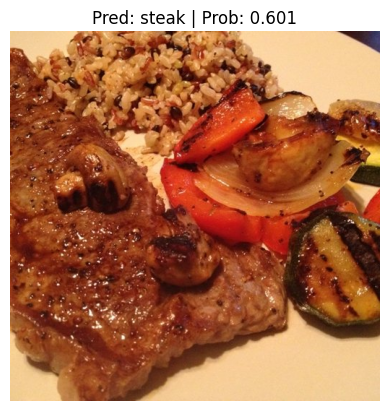

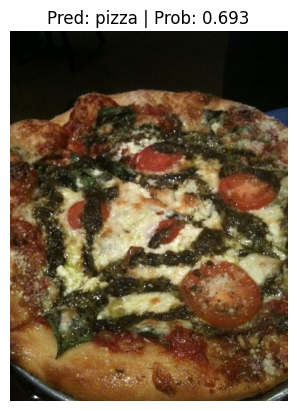

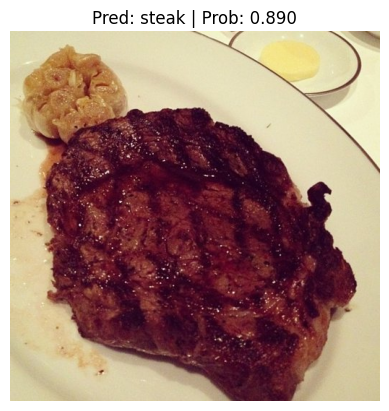

In [38]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / 'test').glob('*/*.jpg'))
test_image_path_sample = random.sample(
    population=test_image_path_list,
    k=num_images_to_plot
)

for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=best_model,
        image_path=image_path,
        class_names=class_names,
        image_size=(224, 224)
    )

data/04-pizza-dad.jpeg already exists, skipping download.


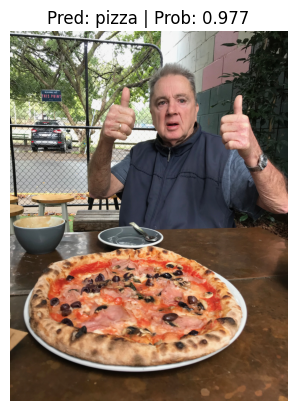

In [39]:
import requests

custom_image_path = Path('data/04-pizza-dad.jpeg')

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f'Downloading {custom_image_path}...')
        f.write(request.content)
else:
    print(custom_image_path, 'already exists, skipping download.')

pred_and_plot_image(
    model=model,
    image_path=custom_image_path,
    class_names=class_names
)